### В этом ноутбуке все про комбинацию метрик

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
df = pd.read_csv('/content/metrics_and_hyperparameter_results_optimized.csv')

In [73]:
metric_columns = [col for col in df.columns if col.startswith('metric_')]
df_metrics = df[metric_columns + ['accuracy']]

correlations = df_metrics.corr()['accuracy'].drop('accuracy').sort_values()

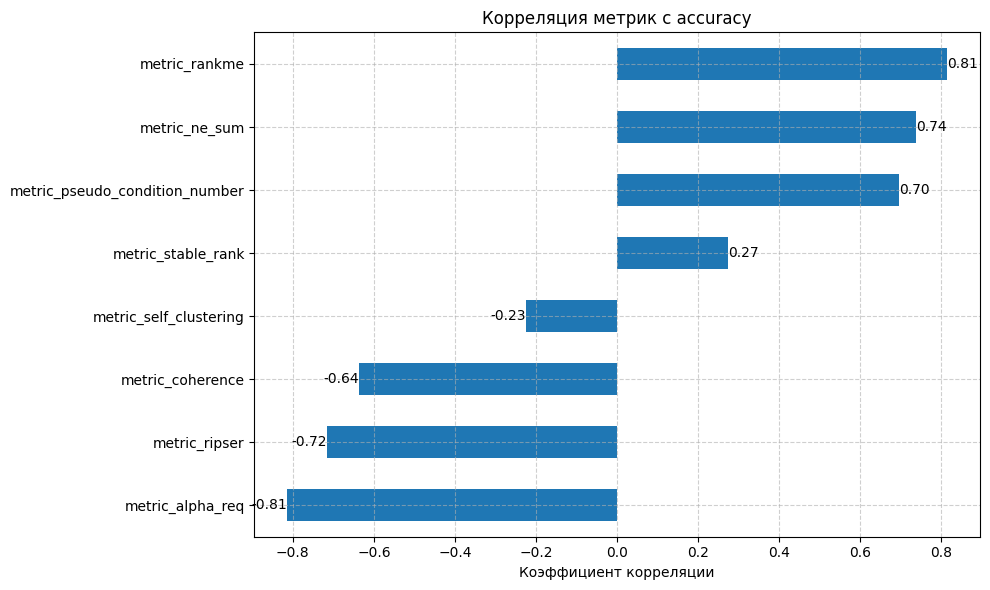

In [74]:
plt.figure(figsize=(10, 6))
ax = correlations.plot(kind='barh')
plt.title('Корреляция метрик с accuracy')
plt.xlabel('Коэффициент корреляции')
plt.grid(True, linestyle='--', alpha=0.6)

for i, (index, value) in enumerate(correlations.items()):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left' if value > 0 else 'right')

plt.tight_layout()
plt.show()

## Обучим простую линейную модель

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[metric_columns])
y = df['accuracy'].values


model = LinearRegression()
model.fit(X_scaled, y)


coefficients = pd.Series(model.coef_, index=metric_columns)


linear_combination = X_scaled @ model.coef_


correlation = np.corrcoef(linear_combination, y)[0, 1]


coefficients_sorted = coefficients.sort_values(key=abs, ascending=False)

coefficients_sorted, correlation

(metric_self_clustering            0.121492
 metric_stable_rank                0.120893
 metric_alpha_req                 -0.020288
 metric_rankme                    -0.016406
 metric_ripser                    -0.012633
 metric_ne_sum                    -0.007897
 metric_pseudo_condition_number    0.003779
 metric_coherence                  0.000149
 dtype: float64,
 np.float64(0.8719136017997359))

## Посмотрим на то, как она ведет себя на других датасетах

In [76]:
paths = {
    "Gender dataset": "/content/metrics_and_hyperparameter_results_optimized.csv",
    "Age dataset": "/content/age_tr_params_tun_full.csv",
    "Churn dataset": "/content/rosbank_grupped_params_tun.csv"
}

datasets = {name: pd.read_csv(path) for name, path in paths.items()}

In [77]:
results = []

# Перебираем пары: обучить на A → применить к B
for train_name, train_df in datasets.items():
    X_train = train_df[metric_columns]
    y_train = train_df["accuracy"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    linreg = LinearRegression()
    linreg.fit(X_train_scaled, y_train)

    for test_name, test_df in datasets.items():
        X_test = test_df[metric_columns]
        y_test = test_df["accuracy"]

        X_test_scaled = scaler.transform(X_test)
        combined_metric = X_test_scaled @ linreg.coef_

        corr = np.corrcoef(combined_metric, y_test)[0, 1]

        results.append({
            "Train On": train_name,
            "Test On": test_name,
            "Correlation": corr
        })

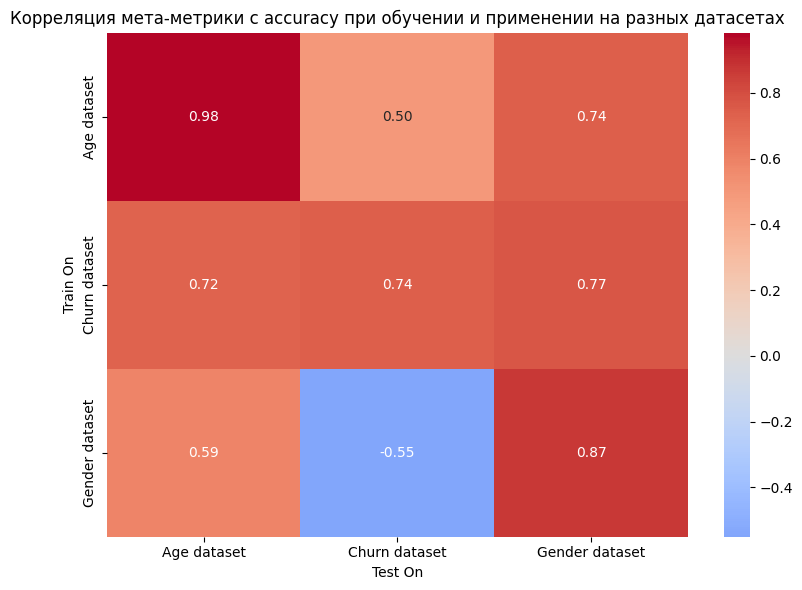

In [78]:
df_results = pd.DataFrame(results)
pivot = df_results.pivot(index="Train On", columns="Test On", values="Correlation")

# Визуализация heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляция мета-метрики с accuracy при обучении и применении на разных датасетах")
plt.tight_layout()
plt.show()

In [79]:
df_results

,Train On,Test On,Correlation
0,Gender dataset,Gender dataset,0.871914
1,Gender dataset,Age dataset,0.586818
2,Gender dataset,Churn dataset,-0.550113
3,Age dataset,Gender dataset,0.738869
4,Age dataset,Age dataset,0.983620
5,Age dataset,Churn dataset,0.495394
6,Churn dataset,Gender dataset,0.772310
7,Churn dataset,Age dataset,0.723240
8,Churn dataset,Churn dataset,0.739275


Она плохо работает.

## Обучим что-то посложнее

In [80]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np

# Создаём пайплайн: стандартизация + SVR
svr_model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.01))

# Признаки — метрики, цель — accuracy
X = df[metric_columns]
y = df['accuracy']

# Кросс-валидация для оценки качества
scores = cross_val_score(svr_model, X, y, cv=5, scoring='r2')
mean_r2 = scores.mean()

# Обучаем на всём датасете
svr_model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.01))])

In [81]:
y_pred_svr = svr_model.predict(X)

# Корреляция между предсказанным значением и реальной accuracy
correlation_svr = np.corrcoef(y_pred_svr, y)[0, 1]

mean_r2, correlation_svr

(np.float64(-1.7606916476884085), np.float64(0.9092755077021697))

In [82]:
from sklearn.inspection import permutation_importance

# Вычисляем важности
result = permutation_importance(svr_model, X, y, n_repeats=30, random_state=42)

# Преобразуем в удобную форму
importances_svr = pd.Series(result.importances_mean, index=metric_columns).sort_values(key=abs, ascending=False)
importances_svr

,0
metric_ripser,0.497909
metric_ne_sum,0.270926
metric_rankme,0.244466
metric_pseudo_condition_number,0.238094
metric_stable_rank,0.152765
metric_coherence,0.146523
metric_alpha_req,0.113551
metric_self_clustering,0.101869


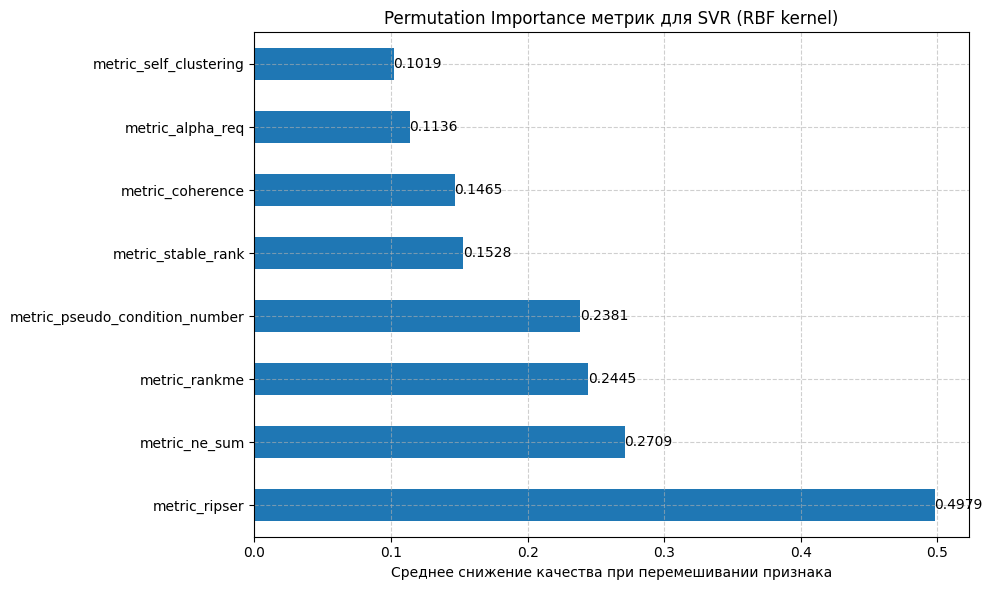

In [83]:
plt.figure(figsize=(10, 6))
importances_svr.plot(kind='barh')
plt.title('Permutation Importance метрик для SVR (RBF kernel)')
plt.xlabel('Среднее снижение качества при перемешивании признака')
plt.grid(True, linestyle='--', alpha=0.6)

# Добавим подписи
for i, (index, value) in enumerate(importances_svr.items()):
    plt.text(value, i, f'{value:.4f}', va='center', ha='left' if value > 0 else 'right')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt

X = df[metric_columns]
y = df['accuracy']


gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr.fit(X, y)

GradientBoostingRegressor(random_state=42)

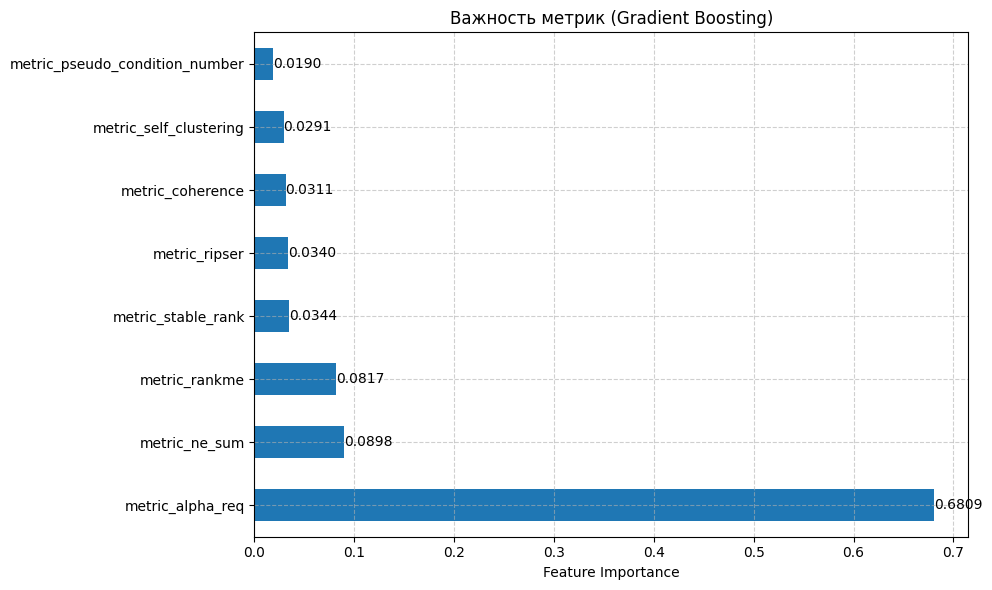

In [ ]:
importances_gbr = pd.Series(gbr.feature_importances_, index=metric_columns).sort_values(ascending=False)


plt.figure(figsize=(10, 6))
importances_gbr.plot(kind='barh')
plt.title('Важность метрик (Gradient Boosting)')
plt.xlabel('Feature Importance')
plt.grid(True, linestyle='--', alpha=0.6)
for i, (index, value) in enumerate(importances_gbr.items()):
    plt.text(value, i, f'{value:.4f}', va='center', ha='left' if value > 0 else 'right')
plt.tight_layout()
plt.show()

In [86]:
y_pred_gbr = gbr.predict(X)

# Корреляция предсказанной комбинации с accuracy
correlation_gbr = np.corrcoef(y_pred_gbr, y)[0, 1]

correlation_gbr

np.float64(0.9924243010685891)

## Посмотрим, что будет на тестовом датасете

In [87]:
df_new = pd.read_csv('/content/rosbank_grupped_params_tun.csv')
available_metrics = [col for col in metric_columns if col in df_new.columns]

In [88]:
X_new = df_new[available_metrics]

# Предсказание accuracy на новом датасете
y_pred_new = gbr.predict(X_new)

Просто получим предсказание той же модели на новом датасете

In [89]:
correlation = np.corrcoef(df_new['accuracy'], y_pred_new)[0, 1]
print(f"Корреляция между predicted_accuracy и accuracy: {correlation:.4f} для бустинга")

Корреляция между predicted_accuracy и accuracy: 0.0206 для бустинга


In [90]:
y_pred_new_svr = svr_model.predict(X_new)

In [91]:
correlation_svr_new = np.corrcoef(df_new['accuracy'], y_pred_new_svr)[0, 1]

In [92]:
print(f"Корреляция между predicted_accuracy и accuracy: {correlation_svr_new:.4f} для svr")

Корреляция между predicted_accuracy и accuracy: 0.1512 для svr


**Вывод**

Плохо они работают, просто предсказывать нельзя.

## Глобализируем по-другому

In [93]:
boosting_weights = importances_gbr / importances_gbr.sum()

# Вычисление линейной комбинации метрик
df_new['boosting_combination'] = X_new @ boosting_weights

In [94]:
correlation_boosting_comb = np.corrcoef(df_new['boosting_combination'], df_new['accuracy'])[0, 1]
correlation_boosting_comb

np.float64(-0.6133389438788339)

In [95]:
svr_weights = importances_svr / importances_svr.sum()

# Линейная комбинация метрик на новом датасете
df_new['svr_combination'] = X_new @ svr_weights

In [96]:
correlation_svr_comb = np.corrcoef(df_new['svr_combination'], df_new['accuracy'])[0, 1]
correlation_svr_comb

np.float64(-0.6073641677912269)

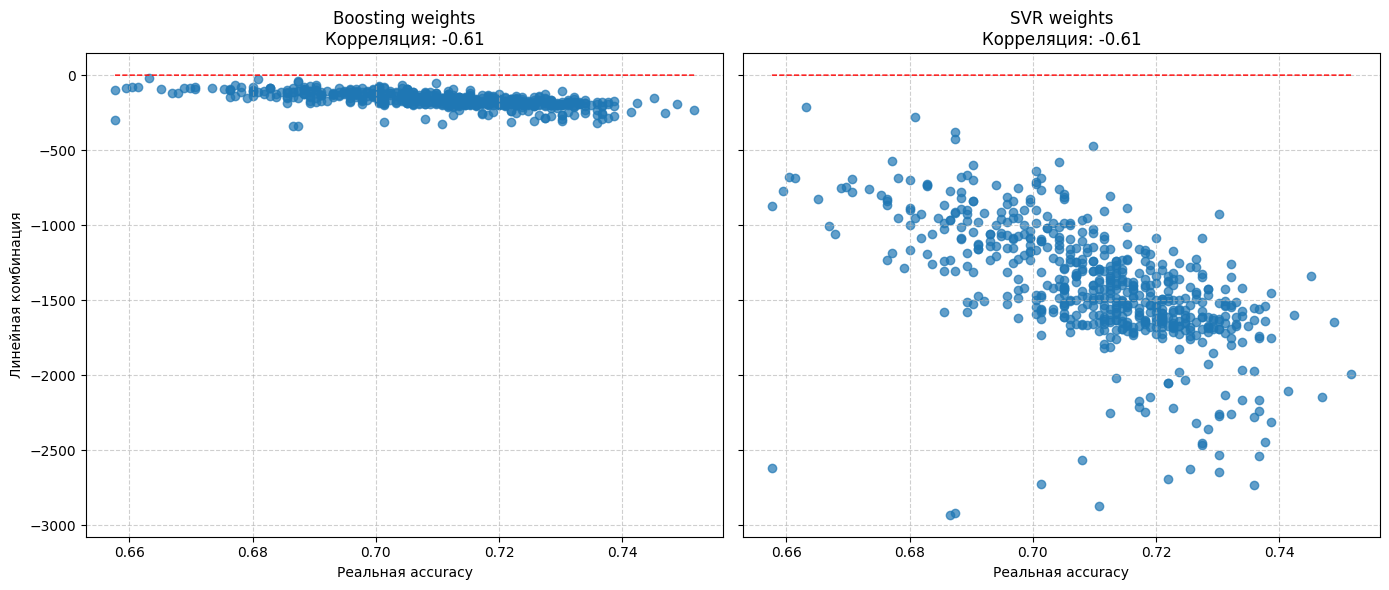

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].scatter(df_new['accuracy'], df_new['boosting_combination'], alpha=0.7)
axes[0].set_title(f'Boosting weights\nКорреляция: {correlation_boosting_comb:.2f}')
axes[0].set_xlabel('Реальная accuracy')
axes[0].set_ylabel('Линейная комбинация')

axes[1].scatter(df_new['accuracy'], df_new['svr_combination'], alpha=0.7)
axes[1].set_title(f'SVR weights\nКорреляция: {correlation_svr_comb:.2f}')
axes[1].set_xlabel('Реальная accuracy')

for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.plot([df_new['accuracy'].min(), df_new['accuracy'].max()],
            [df_new['accuracy'].min(), df_new['accuracy'].max()],
            color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

## Вспоминаем, что надо использовать скейлер

In [98]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

In [99]:
scaler = StandardScaler()
X_new_scaled = pd.DataFrame(scaler.fit_transform(X_new), columns=X_new.columns)

df_new['boosting_combination_scaled'] = X_new @ boosting_weights
df_new['svr_combination_scaled'] = X_new_scaled @ svr_weights

In [100]:
results = {}

for name, pred in {
    'boosting': df_new['boosting_combination_scaled'],
    'svr': df_new['svr_combination_scaled']
}.items():
    pearson_corr = np.corrcoef(df_new['accuracy'], pred)[0, 1]
    spearman_corr, _ = spearmanr(df_new['accuracy'], pred)
    r2 = r2_score(df_new['accuracy'], pred)
    mse = mean_squared_error(df_new['accuracy'], pred)
    mae = mean_absolute_error(df_new['accuracy'], pred)

    results[name] = {
        'Pearson': pearson_corr,
        'Spearman': spearman_corr,
        'R²': r2,
        'MSE': mse,
        'MAE': mae
    }

In [101]:
results_df = pd.DataFrame(results).T
results_df

,Pearson,Spearman,R²,MSE,MAE
boosting,-0.613339,-0.676788,-1.105374e+08,28999.382236,163.627845
svr,-0.527818,-0.608447,-2.187450e+03,0.574138,0.714321


In [102]:
# Повторный пересчёт Train Pearson корреляций для Boosting и SVR (на исходных метриках)

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

# Загрузка данных
df_old = pd.read_csv('/content/metrics_and_hyperparameter_results_optimized.csv')
df_new = pd.read_csv('/content/rosbank_grupped_params_tun.csv')

# Метрики
metric_columns = [col for col in df_old.columns if col.startswith('metric_')]
X = df_old[metric_columns]
y = df_old['accuracy']
X_new = df_new[metric_columns]
y_new = df_new['accuracy']

# Boosting
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr.fit(X, y)
boosting_weights = pd.Series(gbr.feature_importances_, index=metric_columns)
boosting_weights /= boosting_weights.sum()
train_comb_boosting = X @ boosting_weights
test_comb_boosting = X_new @ boosting_weights

# SVR (без масштабирования)
svr_pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.01))
svr_pipeline.fit(X, y)
svr_result = permutation_importance(svr_pipeline, X, y, n_repeats=30, random_state=42)
svr_weights = pd.Series(svr_result.importances_mean, index=metric_columns)
svr_weights /= svr_weights.sum()
train_comb_svr = X @ svr_weights
test_comb_svr = X_new @ svr_weights

# Линейная регрессия (стандартизированная)
scaler_linreg = StandardScaler()
X_scaled = scaler_linreg.fit_transform(X)
X_new_scaled = scaler_linreg.transform(X_new)
linreg_model = LinearRegression()
linreg_model.fit(X_scaled, y)
linreg_weights = pd.Series(linreg_model.coef_, index=metric_columns)
train_comb_linreg = X_scaled @ linreg_weights
test_comb_linreg = X_new_scaled @ linreg_weights

# Корреляции
summary_fixed = pd.DataFrame([
    {
        'Model': 'Boosting',
        'Train_Pearson': np.corrcoef(train_comb_boosting, y)[0, 1],
        'Test_Pearson': np.corrcoef(test_comb_boosting, y_new)[0, 1]
    },
    {
        'Model': 'SVR_raw',
        'Train_Pearson': np.corrcoef(train_comb_svr, y)[0, 1],
        'Test_Pearson': np.corrcoef(test_comb_svr, y_new)[0, 1]
    },
    {
        'Model': 'LinReg_scaled',
        'Train_Pearson': np.corrcoef(train_comb_linreg, y)[0, 1],
        'Test_Pearson': np.corrcoef(test_comb_linreg, y_new)[0, 1]
    }
])
summary_fixed['Delta'] = summary_fixed['Train_Pearson'] - summary_fixed['Test_Pearson']
summary_fixed = summary_fixed.sort_values(by='Test_Pearson', ascending=False)

summary_fixed

,Model,Train_Pearson,Test_Pearson,Delta
2,LinReg_scaled,0.871914,-0.550113,1.422027
1,SVR_raw,-0.715996,-0.607364,-0.108632
0,Boosting,-0.716070,-0.613339,-0.102732


## Строим лин рег, которая предсказывает значение бустинга/ svr

In [103]:
print(y_pred_gbr.shape)
print(y_pred_svr.shape)

(101,)
(101,)


In [104]:
np.corrcoef(y_pred_svr, y_pred_gbr)[0, 1]

np.float64(0.9411637398551241)

In [105]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_new_scaled = scaler.transform(X_new)

linreg_gbr = LinearRegression().fit(X_scaled, y_pred_gbr)
linreg_svr = LinearRegression().fit(X_scaled, y_pred_svr)

In [106]:
combined_train_gbr = X_scaled @ linreg_gbr.coef_
combined_test_gbr = X_new_scaled @ linreg_gbr.coef_

combined_train_svr = X_scaled @ linreg_svr.coef_
combined_test_svr = X_new_scaled @ linreg_svr.coef_

In [107]:
summary_projection = pd.DataFrame([
    {
        'Model': 'Projected GBR',
        'Train_Pearson': np.corrcoef(combined_train_gbr, y)[0, 1],
        'Test_Pearson': np.corrcoef(combined_test_gbr, y_new)[0, 1]
    },
    {
        'Model': 'Projected SVR',
        'Train_Pearson': np.corrcoef(combined_train_svr, y)[0, 1],
        'Test_Pearson': np.corrcoef(combined_test_svr, y_new)[0, 1]
    }
])
summary_projection['Delta'] = summary_projection['Train_Pearson'] - summary_projection['Test_Pearson']
summary_projection = summary_projection.sort_values(by='Test_Pearson', ascending=False)

In [108]:
summary_projection

,Model,Train_Pearson,Test_Pearson,Delta
1,Projected SVR,0.867899,-0.541780,1.409679
0,Projected GBR,0.871837,-0.549081,1.420918


In [109]:
metric_columns = [col for col in df.columns if col.startswith("metric_")]
df["dataset_type"] = df["epoch_num"].apply(lambda x: "Train" if x < df["epoch_num"].max() * 0.8 else "Validation")
# metrics = [col for col in df.columns if col.startswith("metric_")]  + ['combined_metric']

In [110]:
df_corr = df[metric_columns + ["dataset_type", "accuracy"]]

In [111]:
df_corr["GBR"] = combined_train_gbr
df_corr["SVR"] = combined_train_svr

<ipython-input-111-febe50e3ae62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr["GBR"] = combined_train_gbr
<ipython-input-111-febe50e3ae62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr["SVR"] = combined_train_svr


In [112]:
metrics = [col for col in df.columns if col.startswith("metric_")] + ['GBR', 'SVR']

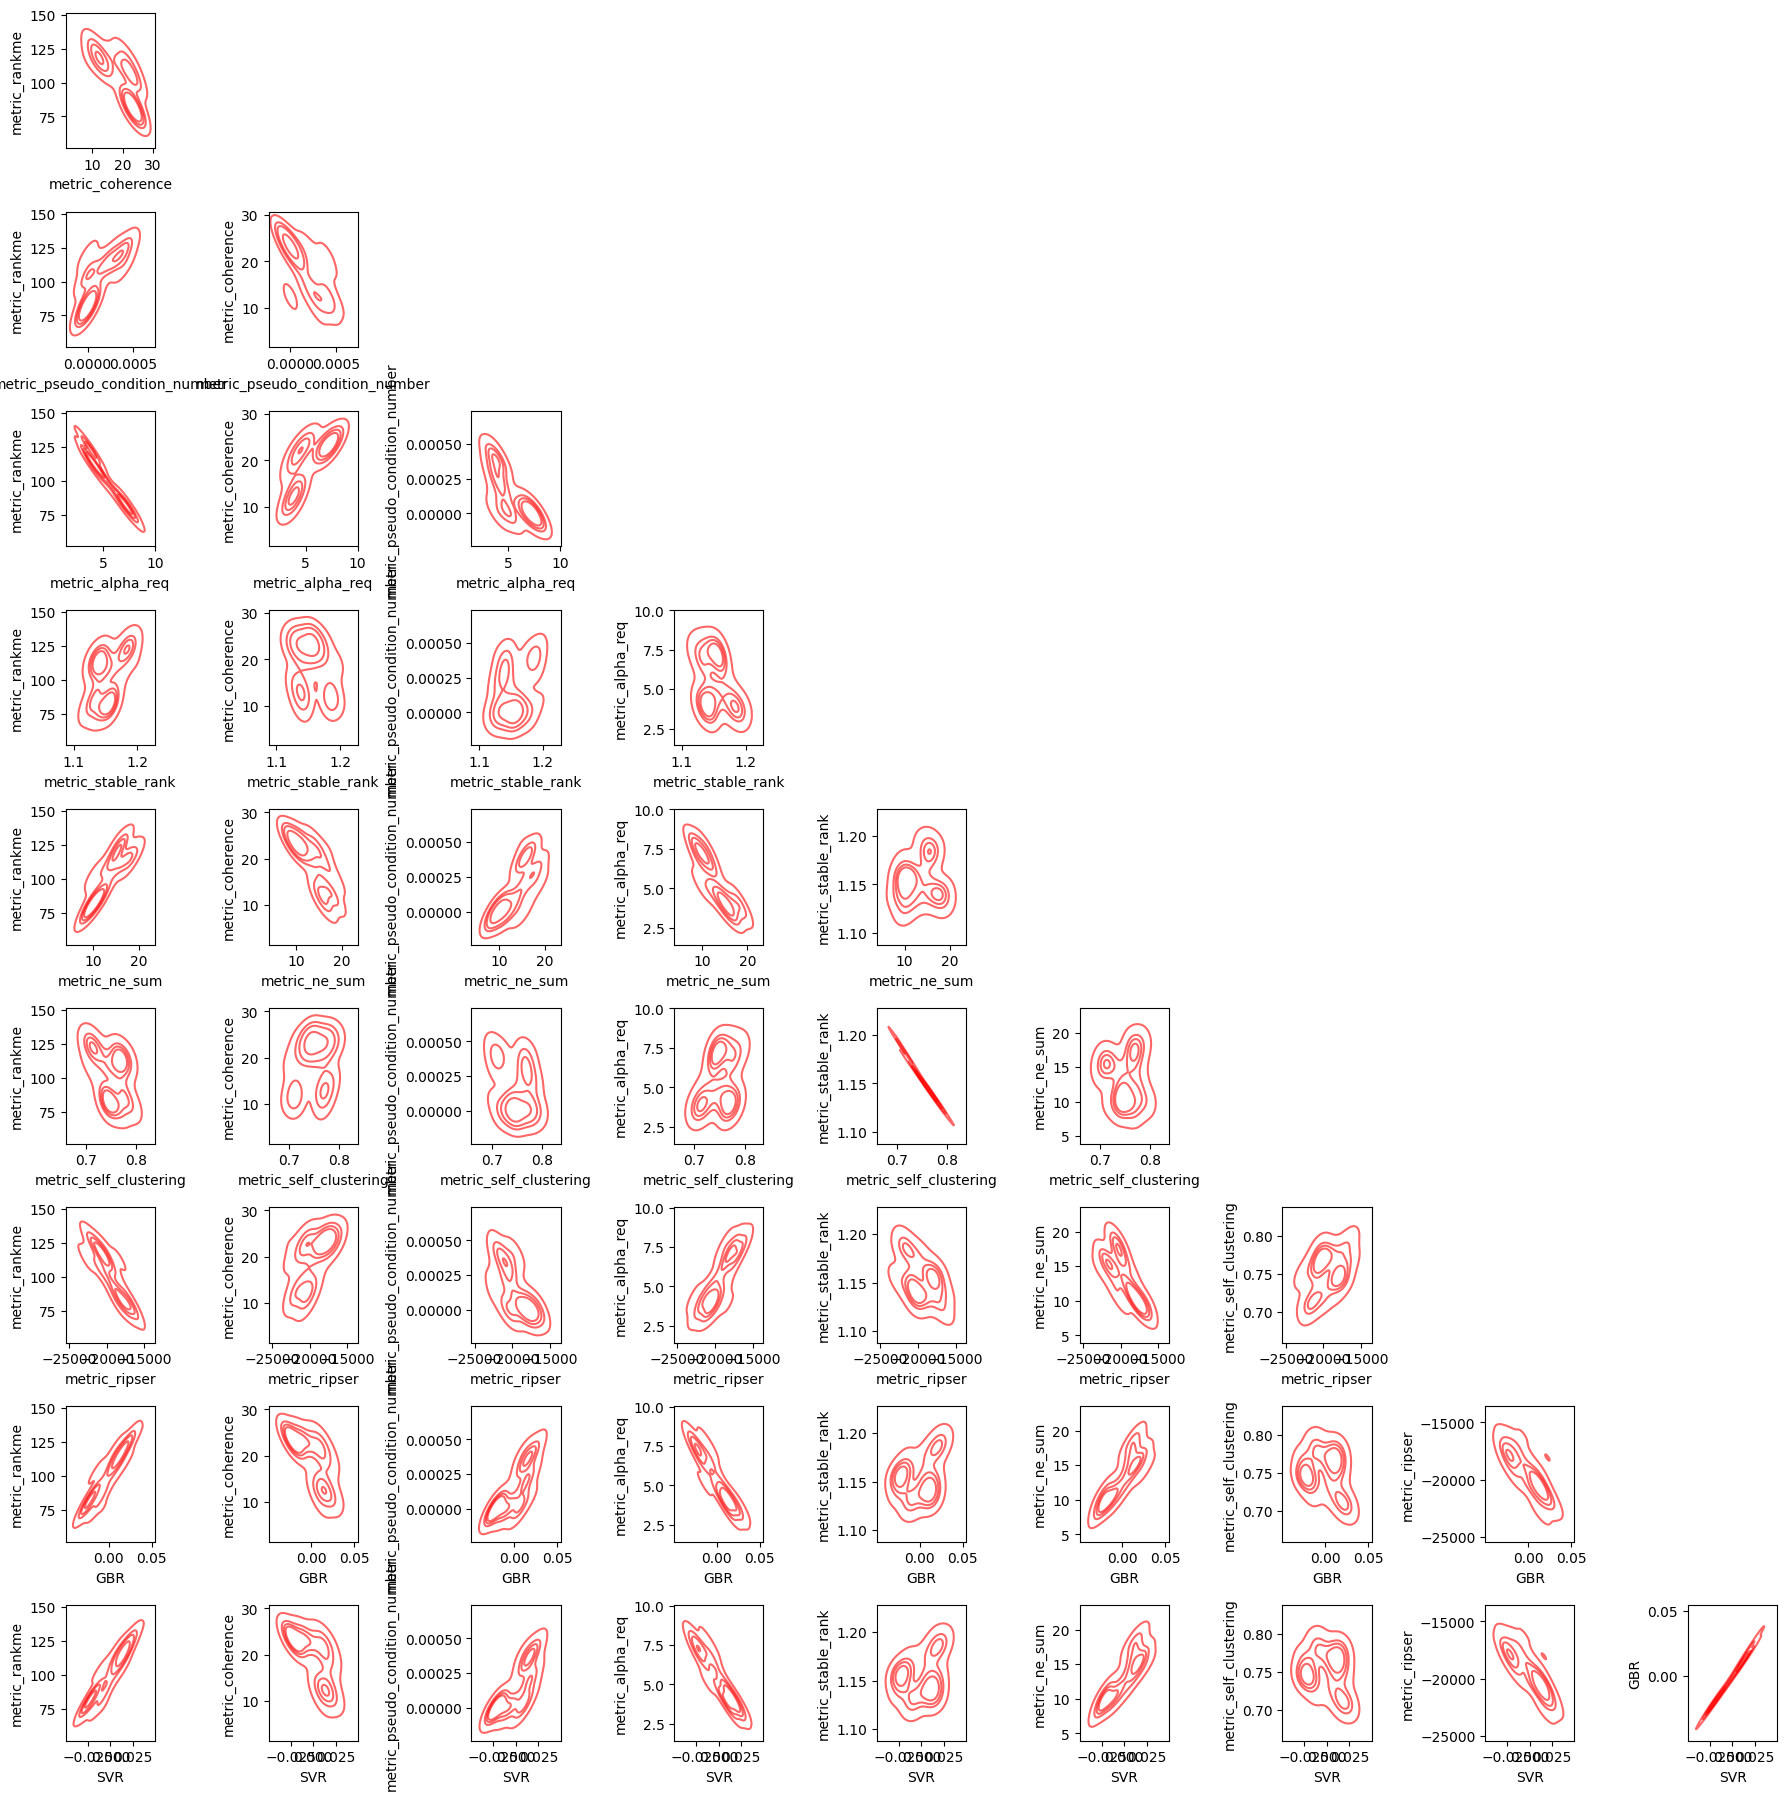

In [113]:


fig, axes = plt.subplots(len(metrics), len(metrics), figsize=(20, 20))

for i, metric_x in enumerate(metrics):
    for j, metric_y in enumerate(metrics):
        ax = axes[i, j]
        if i > j:  # Заполняем только нижний треугольник
            sns.kdeplot(
                x=df_corr.loc[df_corr["dataset_type"] == "Train", metric_x],
                y=df_corr.loc[df_corr["dataset_type"] == "Train", metric_y],
                levels=5, color="red", ax=ax, alpha=0.6
            )
            # sns.kdeplot(
            #     x=df_corr.loc[df_corr["dataset_type"] == "Validation", metric_x],
            #     y=df_corr.loc[df_corr["dataset_type"] == "Validation", metric_y],
            #     levels=5, color="blue", ax=ax, alpha=0.6
            # )
        else:
            ax.set_visible(False)

plt.tight_layout()
plt.show()


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

# Загрузка трёх датасетов
paths = {
    "Dataset 1 (Gender)": "/content/metrics_and_hyperparameter_results_optimized.csv",
    "Dataset 2 (Age)": "/content/age_tr_params_tun_full.csv",
    "Dataset 3 (Churn)": "/content/rosbank_grupped_params_tun.csv"
}
datasets = {name: pd.read_csv(path) for name, path in paths.items()}

metric_columns = [col for col in list(datasets.values())[0].columns if col.startswith("metric_")]

all_results = []

for train_name, train_df in datasets.items():
    X_train = train_df[metric_columns]
    y_train = train_df["accuracy"]

    svr_pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.01))
    svr_pipeline.fit(X_train, y_train)
    y_pred_svr = svr_pipeline.predict(X_train)  # ← fixed

    # Boosting
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    gbr.fit(X_train, y_train)
    y_pred_gbr = gbr.predict(X_train)

    # Обучение линейных моделей на предсказания
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    linreg_gbr = LinearRegression().fit(X_scaled, y_pred_gbr)
    linreg_svr = LinearRegression().fit(X_scaled, y_pred_svr)

    print(np.corrcoef(y_pred_svr, y_pred_gbr)[0, 1])

    boosting_weights = pd.Series(linreg_gbr.coef_, index=metric_columns)
    svr_weights = pd.Series(linreg_svr.coef_, index=metric_columns)

    # Стандартная линейная модель
    linreg_model = LinearRegression()
    X_train_scaled = scaler.fit_transform(X_train)
    linreg_model.fit(X_train_scaled, y_train)
    linreg_weights = pd.Series(linreg_model.coef_, index=metric_columns)

    for test_name, test_df in datasets.items():
        X_test = test_df[metric_columns]
        y_test = test_df["accuracy"]

        X_test_scaled = scaler.transform(X_test)

        result = {
            "Train": train_name,
            "Test": test_name,
            "Boosting": np.corrcoef(X_test_scaled @ boosting_weights, y_test)[0, 1],
            "SVR_raw": np.corrcoef(X_test_scaled @ svr_weights, y_test)[0, 1],
            "LinReg_scaled": np.corrcoef(X_test_scaled @ linreg_weights, y_test)[0, 1]
        }
        all_results.append(result)

results_df = pd.DataFrame(all_results)

0.9411637398551241
0.9919485577748826
0.9557012830385267


In [125]:
results_df

,Train,Test,Boosting,SVR_raw,LinReg_scaled
0,Dataset 1 (Gender),Dataset 1 (Gender),0.871837,0.867899,0.871914
1,Dataset 1 (Gender),Dataset 2 (Age),0.588997,0.608126,0.586818
2,Dataset 1 (Gender),Dataset 3 (Churn),-0.549081,-0.541780,-0.550113
3,Dataset 2 (Age),Dataset 1 (Gender),0.740763,0.735154,0.738869
4,Dataset 2 (Age),Dataset 2 (Age),0.983576,0.982798,0.983620
5,Dataset 2 (Age),Dataset 3 (Churn),0.506724,0.557106,0.495394
6,Dataset 3 (Churn),Dataset 1 (Gender),0.772955,0.763654,0.772310
7,Dataset 3 (Churn),Dataset 2 (Age),0.729138,0.728437,0.723240
8,Dataset 3 (Churn),Dataset 3 (Churn),0.738950,0.737839,0.739275


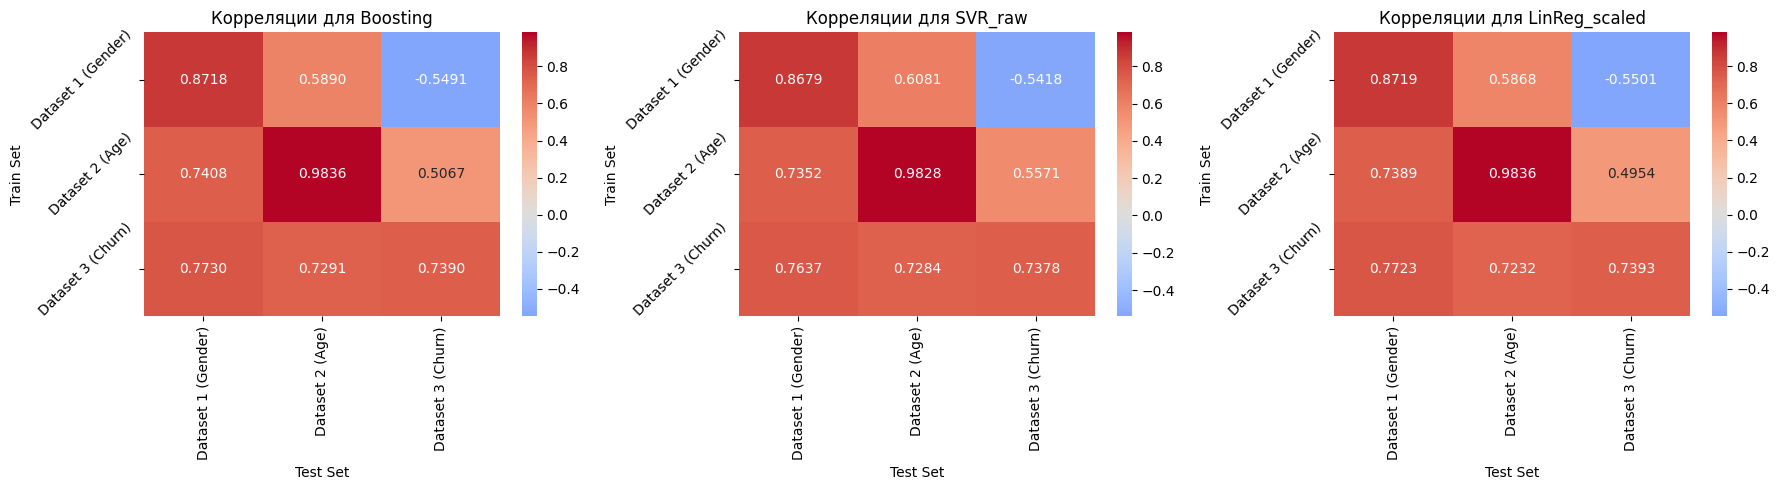

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразуем данные в формат heatmap'ов
models = ["Boosting", "SVR_raw", "LinReg_scaled"]
heatmap_data = {}

# Строим таблицы корреляций по каждой модели
for model in models:
    pivot = results_df.pivot(index="Train", columns="Test", values=model)
    heatmap_data[model] = pivot

# Отрисовка heatmap'ов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model in zip(axes, models):
    sns.heatmap(heatmap_data[model], annot=True, cmap="coolwarm", center=0, fmt=".4f", ax=ax)
    ax.set_title(f"Корреляции для {model}")
    ax.set_xlabel("Test Set")
    ax.set_ylabel("Train Set")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

plt.tight_layout()
plt.show()


## Теперь пойдем в обратную сторону

In [117]:
X_train = df_new[metric_columns]
y_train = df_new['accuracy']
X_test = df_old[metric_columns]
y_test = df_old['accuracy']

In [118]:
gbr_new = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr_new.fit(X_train, y_train)
y_pred_gbr_new = gbr_new.predict(X_train)


In [119]:
svr_pipeline_new = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.01))
svr_pipeline_new.fit(X_train, y_train)
y_pred_svr_new = svr_pipeline_new.predict(X_train)

In [120]:
scaler_new = StandardScaler()
X_train_scaled = scaler_new.fit_transform(X_train)
X_test_scaled = scaler_new.transform(X_test)

linreg_gbr_new = LinearRegression().fit(X_train_scaled, y_pred_gbr_new)
linreg_svr_new = LinearRegression().fit(X_train_scaled, y_pred_svr_new)

In [121]:
combined_train_gbr = X_train_scaled @ linreg_gbr_new.coef_
combined_test_gbr = X_test_scaled @ linreg_gbr_new.coef_

combined_train_svr = X_train_scaled @ linreg_svr_new.coef_
combined_test_svr = X_test_scaled @ linreg_svr_new.coef_


In [122]:
summary_projection_reverse = pd.DataFrame([
    {
        'Model': 'Projected GBR (trained on NEW)',
        'Train_Pearson': np.corrcoef(combined_train_gbr, y_train)[0, 1],
        'Test_Pearson': np.corrcoef(combined_test_gbr, y_test)[0, 1]
    },
    {
        'Model': 'Projected SVR (trained on NEW)',
        'Train_Pearson': np.corrcoef(combined_train_svr, y_train)[0, 1],
        'Test_Pearson': np.corrcoef(combined_test_svr, y_test)[0, 1]
    }
])
summary_projection_reverse['Delta'] = summary_projection_reverse['Train_Pearson'] - summary_projection_reverse['Test_Pearson']
summary_projection_reverse = summary_projection_reverse.sort_values(by='Test_Pearson', ascending=False)

summary_projection_reverse

,Model,Train_Pearson,Test_Pearson,Delta
0,Projected GBR (trained on NEW),0.738950,0.772955,-0.034005
1,Projected SVR (trained on NEW),0.737839,0.763654,-0.025815
